### Setting Up Environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "./")
import tensorflow as tf
import basic_block, utils, load_data
import time
import os
import matplotlib.pyplot as plt
import numpy as np


### Check https://www.tensorflow.org/tensorboard/r2/get_started for more info
# Load the TensorBoard notebook extension
# For Jupyter notebook
%load_ext tensorboard.notebook
# For Colab
# %load_ext tensorboard
import datetime

### Undo the Preprocessing

In [11]:
def restor_img(img):
    try:
        img = img.numpy()
    except:
        pass
    img -= img.min()
    return img / img.max() 

In [12]:
### https://www.tensorflow.org/tensorboard/r2/get_started
# Define our metrics
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)

### Training Loop

In [13]:
### For training, checkout https://www.tensorflow.org/api_docs/python/tf/keras/models/Model
###                        https://www.tensorflow.org/tensorboard/r2/get_started
def train(style_list, content_list, save_model_dir,batch_size=1, num_epochs=10, style_weight=1, content_weight=1,
          ngf=64, log_interval=1, lr=2e-5):
    ########################
    # Data loader
    ########################

    content_loader = load_data.get_dataloader(content_list, batch_size, target_size=(300,400))
    style_loader = load_data.get_dataloader(style_list, batch_size, target_size=(300, 400))
    
    ########################
    # Init model
    ########################  
    vgg = basic_block.Vgg()
    style_model = basic_block.Net(ngf = ngf)
    ########################
    # optimizer and loss
    ########################
#     mse_loss = tf.losses.mean_squared_error
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    ########################
    # Start training loop
    ########################
    for epoch in range(num_epochs):
        print("Epoch", epoch)
        # Why don't we have style_model.train() method in our code?
        agg_content_loss = 0.0
        agg_style_loss = 0.0
        count = 0
        
        content_loader_iter = iter(content_loader)
        style_loader_iter = iter(style_loader)
        
        for batch_id, content_img in enumerate(content_loader_iter):
            with tf.GradientTape() as tape:
                # Need to watch variables in order to compute their gradients
#                 tape.watch(style_model.trainable_variables)
                
                # Update batch and count number #
                n_batch = len(content_img)
                count += n_batch

                ####### Maybe need to reset the gradient (did so in PyTorch)??
                content_img = utils.preprocess_batch(content_img)
                content_img = np.random.normal(size=content_img.shape).astype('f')  
                # Load style image and initialize gram matrix and other stuff in style_model 
                style_image = next(style_loader_iter)
                style_image = utils.preprocess_batch(style_image) ### We need this line becuase their style_loader.get function performs this preprocessing internally
                style_model.set_target(style_image)
                
                
                plt.imshow(restor_img(style_image[0]))
                plt.title("style")
                plt.show()
                
                plt.imshow(restor_img(content_img[0]))
                plt.title("content")
                plt.show()


                # Normalize the data points based on mean of large dataset in ImageNet and feed it into vgg 
                style_image = utils.subtract_imagenet_mean_batch(style_image)
                feature_style = vgg(style_image)
                gram_style = [utils.gram_matrix(y) for y in feature_style] #### First, this gram matrix is located in wrong file. Second, the tensor used in original paper has shape (b, ch, h, w), whereas somehow we assume (b, h, w, ch) in our implementation 
                
#                 y = style_model(content_img)
#                 xc = content_img ##### Bill is not sure this is correct. But creating a new node in graph doesn't seem correct

                #### This section is for visualization purpose only
#                 print(content_img)
                im = style_model(content_img)[0]
                plt.imshow(restor_img(im))
                plt.title("result")
                plt.show()
                
#                 # Process images which get feed into VGG and used for loss computation
#                 y = utils.subtract_imagenet_mean_batch(y)
#                 xc = utils.subtract_imagenet_mean_batch(xc)
                
                features_y = vgg(utils.subtract_imagenet_mean_batch(style_model(content_img)))
                feature_xc = vgg(utils.subtract_imagenet_mean_batch(content_img))

                f_xc_c = feature_xc[1]
  
                
                #print(y.shape, content_img.shape)
                #print(features_y[1].shape, f_xc_c.shape)
                
                # TODO: why the coefficient 2?
#                 content_loss = 2 * content_weight * tf.math.reduce_sum(mse_loss(features_y[1], f_xc_c,))
                
                
#                 b, h, w, ch = features_y[1].shape
#                 features_y[1] = tf.reshape(features_y[1], [b*h*w, ch])
#                 f_xc_c = tf.reshape(f_xc_c, [b*h*w, ch])
#                 print("Content: ", features_y[1].shape, f_xc_c.shape, np.prod(f_xc_c.shape))
                
#                 print(tf.reduce_sum(tf.pow(features_y[1] - f_xc_c, 2))/ np.prod(f_xc_c.shape))
#                 print(tf.reduce_mean(tf.square(features_y[1] - f_xc_c)))
#                 print(tf.reduce_mean(tf.losses.mean_squared_error(features_y[1], f_xc_c)))
#                 print(tf.math.equal(tf.reduce_mean(tf.square(features_y[1] - f_xc_c)), tf.reduce_mean(tf.losses.mean_squared_error(features_y[1], f_xc_c))))
                
                
                content_loss = content_weight * tf.reduce_mean(tf.square(features_y[1] - f_xc_c))
                
                style_loss = 0.0
                for m in range(len(features_y)):
                
                    
                    gram_y = utils.gram_matrix(features_y[m])
                    gram_s = gram_style[m]
#                     print("Style: ", gram_y.shape, gram_s[:n_batch, :, :].shape)
                    layer_loss = style_weight * tf.reduce_mean(tf.square(gram_y, gram_s[:n_batch, :, :]))
                    print("Loss of layer {} in VGG: {}".format(m+1, layer_loss))
                    style_loss += layer_loss
                total_loss = content_loss + style_loss
                agg_content_loss += content_loss
                agg_style_loss += style_loss

            ### in original code, optimizer performs step immediately after calculating total_loss. Whey do we update gradient outside the tape region??
            ### Also, we do we have variables and trainable_variables????????
            gradients = tape.gradient(total_loss, style_model.variables)
            optimizer.apply_gradients(zip(gradients, style_model.trainable_variables))
            ### https://www.tensorflow.org/tensorboard/r2/get_started
            train_loss(total_loss)
            
            
#             for g, v in zip(gradients, style_model.trainable_variables):
#                 print(v.name)

                
                
            if (batch_id + 1) % log_interval == 0:
                mesg = "{}\tEpoch {}:\tcontent: {:.3f}\tstyle: {:.3f}\ttotal: {:.3f}".format(
                    time.ctime(), epoch + 1,
                                  agg_content_loss / (batch_id + 1),
                                  agg_style_loss / (batch_id + 1),
                                  (agg_content_loss + agg_style_loss) / (batch_id + 1)
                )
                print(mesg)

#             if (batch_id + 1) % (4 * log_interval) == 0:
#                 # save model
#                 save_model_filename = "Epoch_" + str(epoch) + "iters_" + \
#                     str(count) + "_" + str(time.ctime()).replace(' ', '_') + "_" + str(
#                     content_weight) + "_" + str(style_weight) + ".params"
#                 save_model_path = os.path.join(save_model_dir, save_model_filename)
#                 tf.saved_model.save(style_model, save_model_path)
#                 print("\nCheckpoint, trained model saved at", save_model_path)




        ### https://www.tensorflow.org/tensorboard/r2/get_started
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)



        template = 'Epoch {}, Loss: {}' #, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
        print (template.format(epoch+1, train_loss.result())) 
                               #train_accuracy.result()*100,
                               #test_loss.result(), 
                               #test_accuracy.result()*100))

        # Reset metrics every epoch
        train_loss.reset_states()
    return style_model

In [14]:
!rm -rf ./logs/ 
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
# test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
# test_summary_writer = tf.summary.create_file_writer(test_log_dir)

### Sanity Check

Epoch 0


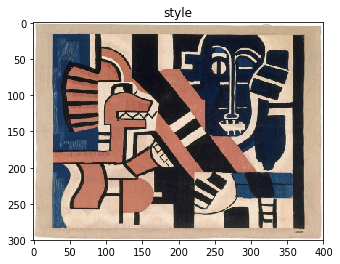

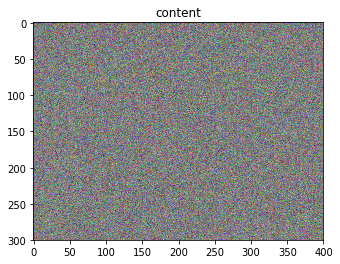

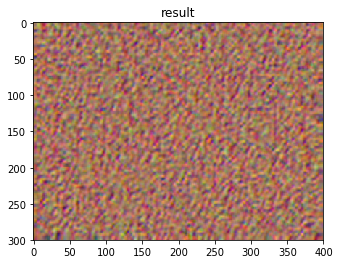

KeyboardInterrupt: 

In [16]:
style_list = load_data.get_data_paths("style")
content_list = load_data.get_data_paths("content")
model = train(style_list, content_list, "models", num_epochs=5, style_weight=1, content_weight=0)

### Loading Tensorboard

In [126]:
%tensorboard --logdir logs/gradient_tape

0
0.0 0.9998946


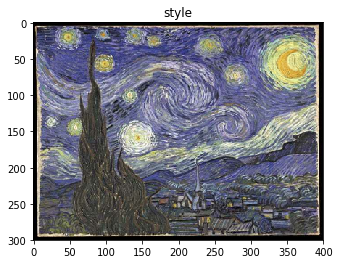

0.0 0.87256575


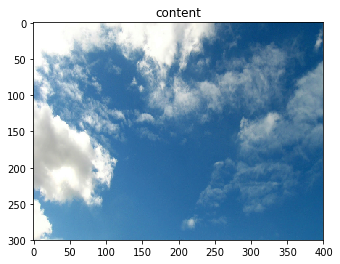

0.0 0.0025402831


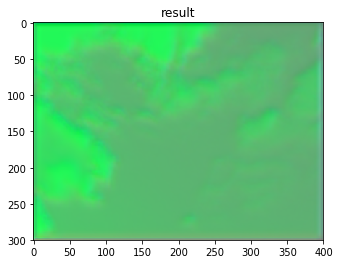

Loss of layer 1 in VGG: 3055424.0
Loss of layer 2 in VGG: 153534.703125
Loss of layer 3 in VGG: 3858.153076171875
Loss of layer 4 in VGG: 0.038913436233997345
Fri May 10 23:01:07 2019	Epoch 1:	content: 67723.945	style: 3212817.000	total: 3280541.000
Epoch 1, Loss: 3280541.0
1
0.0 0.9998946


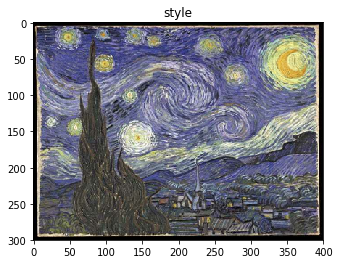

0.0 0.87256575


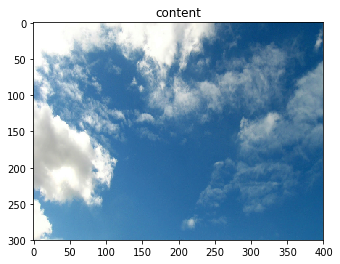

0.0 0.00553981


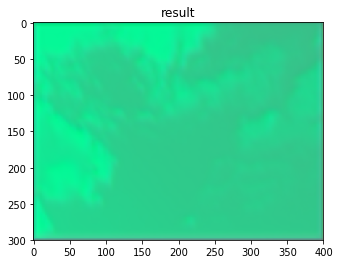

Loss of layer 1 in VGG: 2986371.0
Loss of layer 2 in VGG: 150536.421875
Loss of layer 3 in VGG: 3781.84814453125
Loss of layer 4 in VGG: 0.038459379225969315
Fri May 10 23:01:23 2019	Epoch 2:	content: 67461.633	style: 3140689.250	total: 3208151.000
Epoch 2, Loss: 3208151.0
2
0.0 0.9998946


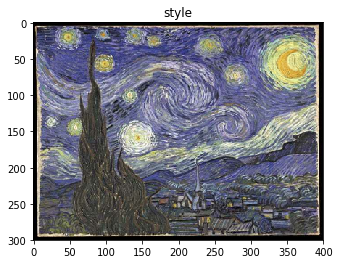

0.0 0.87256575


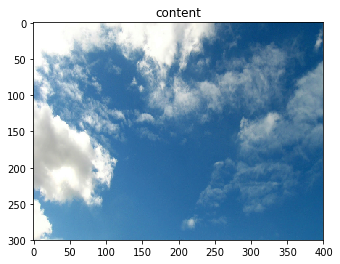

0.0 0.008341132


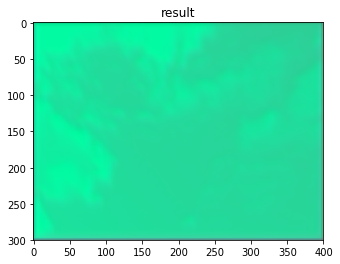

Loss of layer 1 in VGG: 2918142.25
Loss of layer 2 in VGG: 147511.359375
Loss of layer 3 in VGG: 3695.572509765625
Loss of layer 4 in VGG: 0.037811849266290665
Fri May 10 23:01:39 2019	Epoch 3:	content: 67180.336	style: 3069349.000	total: 3136529.250
Epoch 3, Loss: 3136529.25
3
0.0 0.9998946


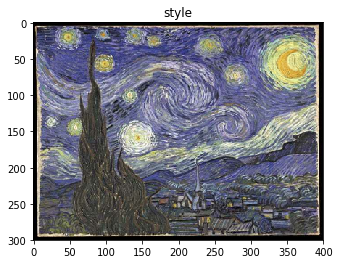

0.0 0.87256575


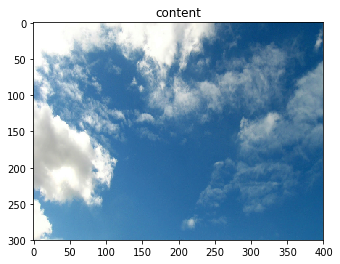

0.0 0.0112214945


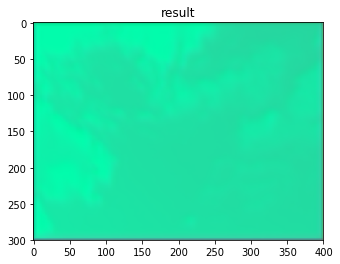

Loss of layer 1 in VGG: 2849510.25
Loss of layer 2 in VGG: 144221.140625
Loss of layer 3 in VGG: 3596.072265625
Loss of layer 4 in VGG: 0.037011343985795975
Fri May 10 23:01:56 2019	Epoch 4:	content: 66850.078	style: 2997327.500	total: 3064177.500
Epoch 4, Loss: 3064177.5
4
0.0 0.9998946


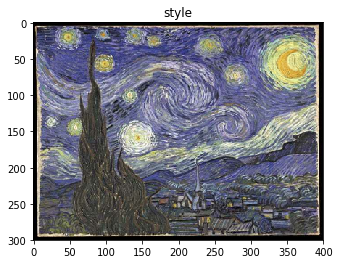

0.0 0.87256575


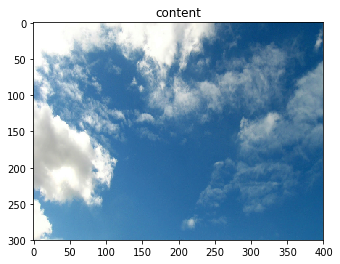

0.0 0.014095392


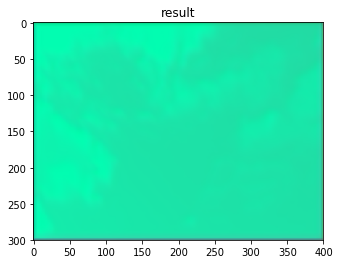

Loss of layer 1 in VGG: 2783532.5
Loss of layer 2 in VGG: 140853.515625
Loss of layer 3 in VGG: 3484.473876953125
Loss of layer 4 in VGG: 0.036109115928411484
Fri May 10 23:02:11 2019	Epoch 5:	content: 66491.500	style: 2927870.500	total: 2994362.000
Epoch 5, Loss: 2994362.0
5
0.0 0.9998946


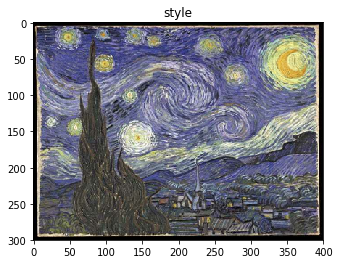

0.0 0.87256575


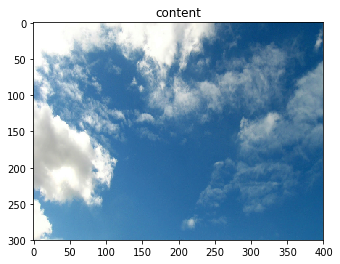

0.0 0.017049052


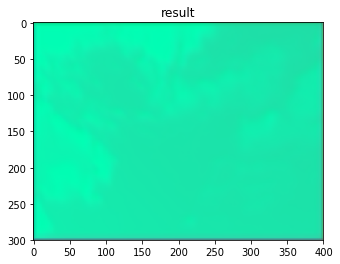

Loss of layer 1 in VGG: 2724039.5
Loss of layer 2 in VGG: 137656.015625
Loss of layer 3 in VGG: 3369.70263671875
Loss of layer 4 in VGG: 0.03525865077972412
Fri May 10 23:02:25 2019	Epoch 6:	content: 66136.031	style: 2865065.250	total: 2931201.250
Epoch 6, Loss: 2931201.25
6
0.0 0.9998946


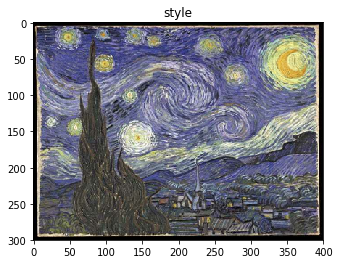

0.0 0.87256575


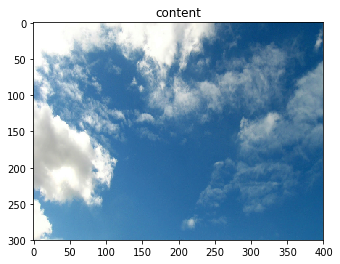

0.0 0.020232327


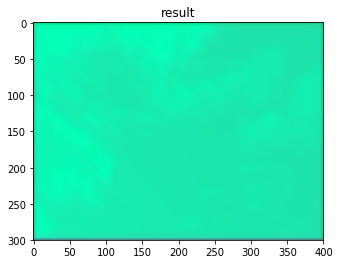

Loss of layer 1 in VGG: 2671050.5
Loss of layer 2 in VGG: 134575.4375
Loss of layer 3 in VGG: 3246.331787109375
Loss of layer 4 in VGG: 0.034342508763074875
Fri May 10 23:02:38 2019	Epoch 7:	content: 65787.531	style: 2808872.250	total: 2874659.750
Epoch 7, Loss: 2874659.75
7
0.0 0.9998946


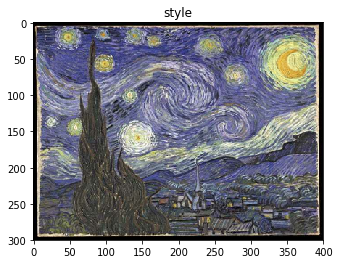

0.0 0.87256575


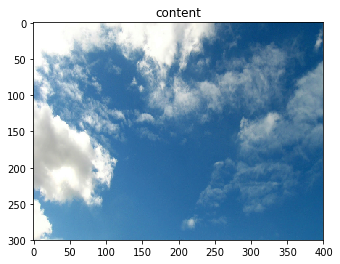

0.0 0.023466326


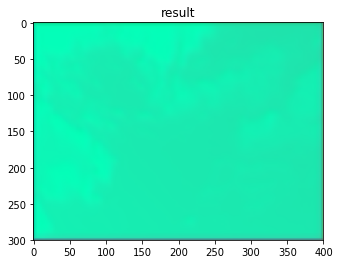

Loss of layer 1 in VGG: 2623522.5
Loss of layer 2 in VGG: 131335.953125
Loss of layer 3 in VGG: 3114.349365234375
Loss of layer 4 in VGG: 0.03340614587068558
Fri May 10 23:02:52 2019	Epoch 8:	content: 65416.355	style: 2757972.750	total: 2823389.000
Epoch 8, Loss: 2823389.0
8
0.0 0.9998946


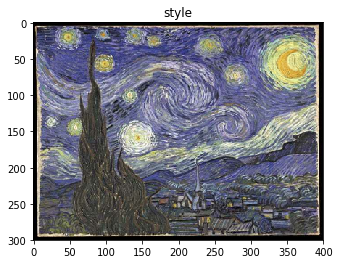

0.0 0.87256575


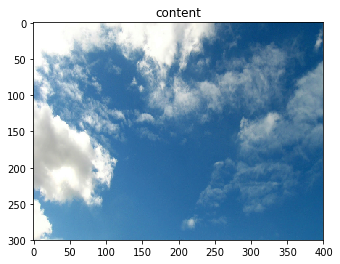

0.0 0.026622437


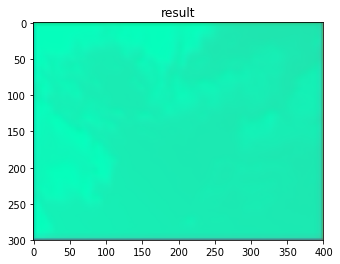

Loss of layer 1 in VGG: 2580867.5
Loss of layer 2 in VGG: 127999.078125
Loss of layer 3 in VGG: 2979.41162109375
Loss of layer 4 in VGG: 0.032428767532110214
Fri May 10 23:03:06 2019	Epoch 9:	content: 65030.363	style: 2711846.000	total: 2776876.250
Epoch 9, Loss: 2776876.25
9
0.0 0.9998946


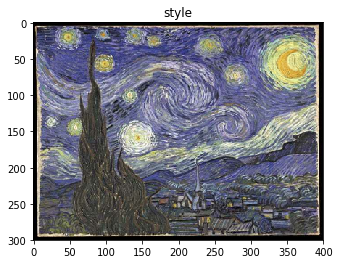

0.0 0.87256575


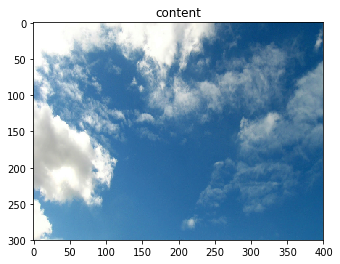

0.0 0.029722784


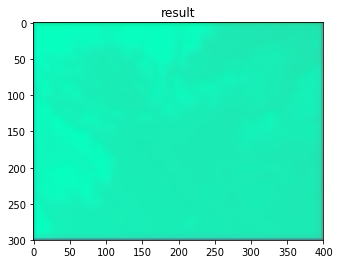

Loss of layer 1 in VGG: 2540014.5
Loss of layer 2 in VGG: 124817.1484375
Loss of layer 3 in VGG: 2859.22314453125
Loss of layer 4 in VGG: 0.0316212996840477
Fri May 10 23:03:19 2019	Epoch 10:	content: 64651.125	style: 2667691.000	total: 2732342.000
Epoch 10, Loss: 2732342.0
10
0.0 0.9998946


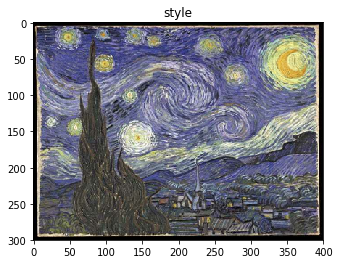

0.0 0.87256575


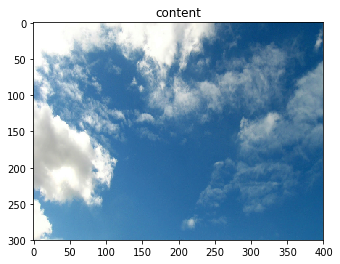

0.0 0.03281224


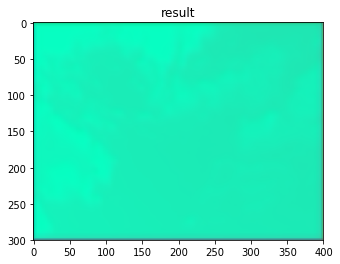

Loss of layer 1 in VGG: 2500391.75
Loss of layer 2 in VGG: 121777.21875
Loss of layer 3 in VGG: 2754.374755859375
Loss of layer 4 in VGG: 0.031011952087283134
Fri May 10 23:03:33 2019	Epoch 11:	content: 64273.859	style: 2624923.250	total: 2689197.000
Epoch 11, Loss: 2689197.0
11
0.0 0.9998946


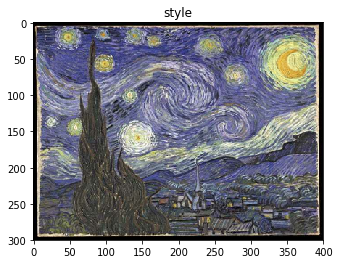

0.0 0.87256575


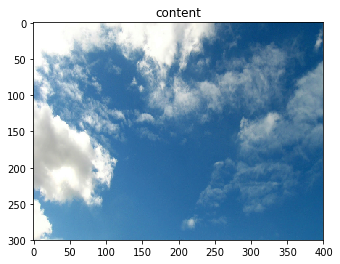

0.0 0.0359087


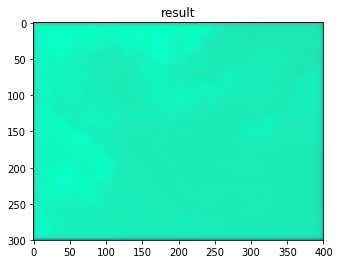

Loss of layer 1 in VGG: 2462155.5
Loss of layer 2 in VGG: 118809.0703125
Loss of layer 3 in VGG: 2656.873046875
Loss of layer 4 in VGG: 0.03058471716940403
Fri May 10 23:03:47 2019	Epoch 12:	content: 63900.980	style: 2583621.250	total: 2647522.250
Epoch 12, Loss: 2647522.25
12
0.0 0.9998946


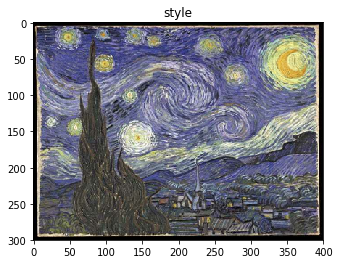

0.0 0.87256575


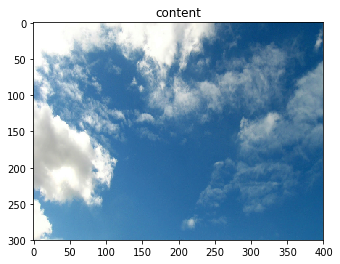

0.0 0.039028723


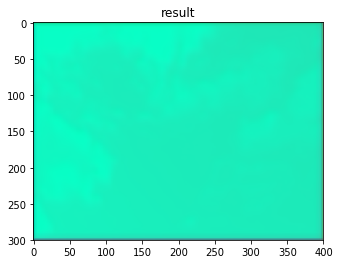

Loss of layer 1 in VGG: 2425817.75
Loss of layer 2 in VGG: 115892.3828125
Loss of layer 3 in VGG: 2566.406005859375
Loss of layer 4 in VGG: 0.030475210398435593
Fri May 10 23:03:58 2019	Epoch 13:	content: 63534.402	style: 2544276.750	total: 2607811.250
Epoch 13, Loss: 2607811.25
13
0.0 0.9998946


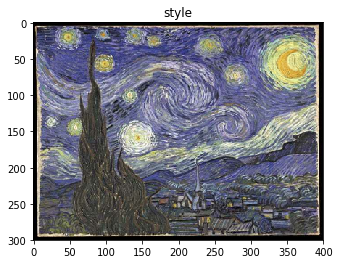

0.0 0.87256575


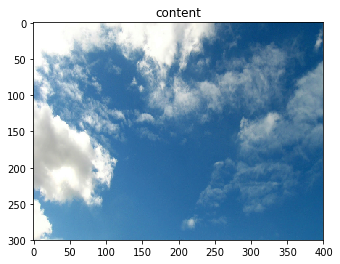

0.0 0.042134672


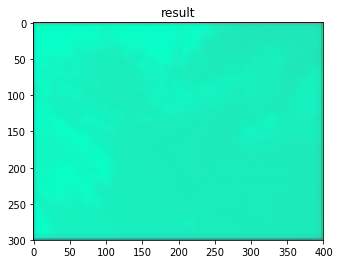

Loss of layer 1 in VGG: 2390773.5
Loss of layer 2 in VGG: 112964.8046875
Loss of layer 3 in VGG: 2480.20361328125
Loss of layer 4 in VGG: 0.030697952955961227


KeyboardInterrupt: 

In [19]:
style_list = load_data.get_data_paths("style")
content_list = load_data.get_data_paths("content")
train(style_list, content_list, "models", num_epochs=50, style_weight=10, content_weight=1)